In [ ]:
import pandas as pd
import numpy as np
import os
import pandas as pds
import re
import numpy as np
import nltk
import seaborn as sbn
import torch
import copy

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from dask import dataframe
from nltk.corpus import words
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, f1_score
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/challenge_log_data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/challenge_log_data/test.csv")
val_sample = pd.read_csv("/content/drive/MyDrive/challenge_log_data/validation_sample.csv")

In [ ]:
len(test)

1418916

## Bert RF


In [ ]:
train = torch.load('/content/drive/MyDrive/challenge_log_data/train_ids.pt')
test = torch.load('/content/drive/MyDrive/challenge_log_data/input_ids.pt')
label = pd.read_csv('/content/drive/MyDrive/challenge_log_data/EDA_Dup_Oversampling (1).csv')

In [ ]:
# 레이블 추출
labels = label['level']

# 레이블 인코딩
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train.to_dense().numpy(),
    labels,
    test_size=0.2,
    random_state=42
)


In [ ]:
# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict and evaluate the model on the validation set
y_pred = rf.predict(test)
results = y_pred
results_prob = rf.predict_proba(test)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/challenge_log_data/sample_submission.csv')
submission['level'] = results
submission['level'].value_counts()

level
0    1003430
1     395941
3      12960
5       6492
2         34
4         34
6         25
Name: count, dtype: int64

Class 0 - Optimal Threshold: 0.38, F1 Score: 0.9466950959488274
Class 1 - Optimal Threshold: 0.57, F1 Score: 0.9969610377829183
Class 2 - Optimal Threshold: 1.0, F1 Score: 1.0
Class 3 - Optimal Threshold: 0.45, F1 Score: 0.9727272727272727
Class 4 - Optimal Threshold: 1.0, F1 Score: 1.0
Class 5 - Optimal Threshold: 0.43, F1 Score: 0.9765258215962441
Class 6 - Optimal Threshold: 1.0, F1 Score: 1.0


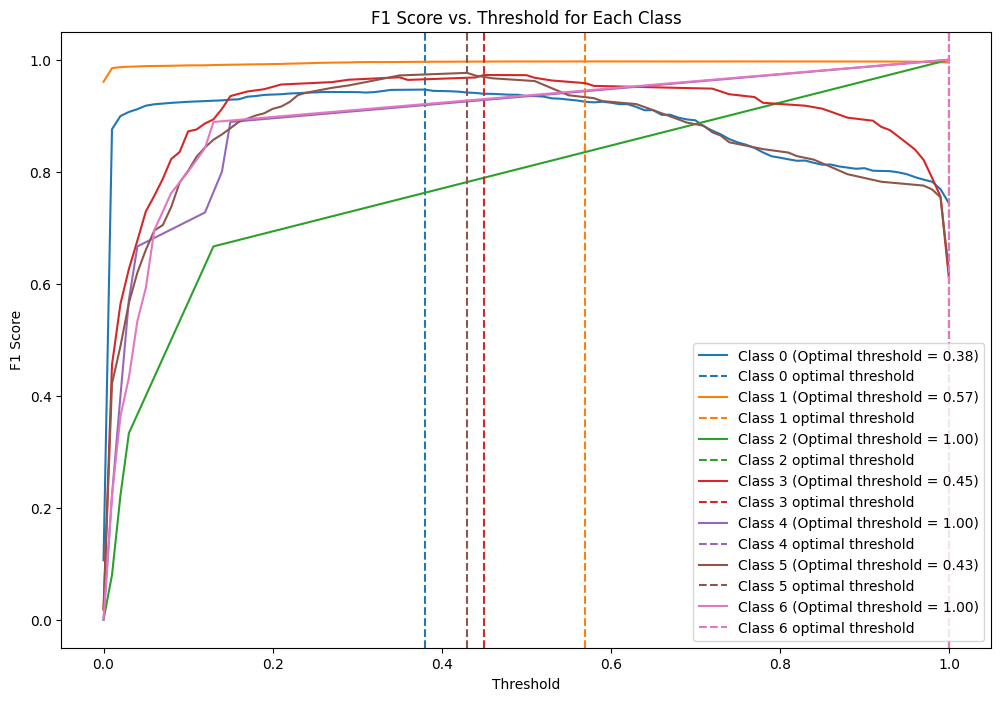

{0: 0.38, 1: 0.57, 2: 1.0, 3: 0.45, 4: 1.0, 5: 0.43, 6: 1.0}


In [ ]:
# Get class labels
classes = np.unique(y_train)

# Find optimal thresholds and plot F1-score vs. Threshold
optimal_thresholds = find_optimal_thresholds_and_plot_f1(rf, X_val, y_val, classes)
print(optimal_thresholds)

##

In [ ]:
# Apply optimal thresholds to predictions and calculate F1-score
y_pred = np.zeros_like(y_val)
for class_label, threshold in optimal_thresholds.items():
    y_pred_prob = rf.predict_proba(X_val)[:, class_label]
    y_pred_class = (y_pred_prob >= threshold).astype(int)
    y_pred[y_pred_class == 1] = class_label

In [ ]:
results[np.where((np.max(results_prob, axis=1)<0.32) & (results == 0))[0]]=7
results[np.where((np.max(results_prob, axis=1)<0.59) & (results == 1))[0]]=7
results[np.where((np.max(results_prob, axis=1)<0.5) & (results == 2))[0]]=7
results[np.where((np.max(results_prob, axis=1)<0.39) & (results == 3))[0]]=7
results[np.where((np.max(results_prob, axis=1)<0.5) & (results == 4))[0]]=7
results[np.where((np.max(results_prob, axis=1)<0.42) & (results == 5))[0]]=7
results[np.where((np.max(results_prob, axis=1)<0.5) & (results == 6))[0]]=7

In [ ]:
submission['level'] = results
submission['level'].value_counts()

level
0    1003413
1     395633
3      12937
5       6463
7        377
2         34
4         34
6         25
Name: count, dtype: int64

In [ ]:
submission.to_csv("/content/drive/MyDrive/challenge_log_data/bert_RF_level_7.csv",index = False)

In [ ]:
joblib.dump(model_data, 'random_forest_model_bert.pkl')

## Data Processing  RF

In [ ]:
import pickle

In [ ]:
file_path = ('/content/drive/MyDrive/challenge_log_data/processed_train_data.pkl')
test_data = pd.read_csv('/content/drive/MyDrive/challenge_log_data/test_with_padded_full_log2.csv')

In [ ]:
with open(file_path, 'rb') as file:
    train_data = pickle.load(file)

In [ ]:
train_data

{'padded_sequences': array([[105,   4,  10, ...,   0,   0,   0],
        [ 90,   4,  11, ...,   0,   0,   0],
        [  7,   4,  10, ...,   0,   0,   0],
        ...,
        [102,   4,  10, ...,   0,   0,   0],
        [  7,   4,  10, ...,   0,   0,   0],
        [102,   4,  10, ...,   0,   0,   0]], dtype=int32),
 'labels': array([0, 0, 0, ..., 0, 0, 0]),
 'vocab_size': 31014,
 'tokenizer': <keras.src.preprocessing.text.Tokenizer at 0x7c57af3f8fd0>,
 'label_encoder': LabelEncoder()}

In [ ]:
test.head()

,id,full_log,padded_full_log
0,1000000,feb localhost kibana typeerrortimestamptzta...,"[90, 4, 10, 359, 221, 185, 356, 221, 185, 105,..."
1,1000001,sep localhost kibana typeerrortimestamptztag...,"[104, 4, 10, 52, 2, 51, 8, 2, 46, 3, 47, 24, 3..."
2,1000002,typesyscall msgaudit archce syscall successyes...,"[30, 1, 31, 32, 40, 29, 253, 197, 6, 6, 33, 34..."
3,1000003,jan localhost kibana typeerrortimestamptztag...,"[7, 4, 10, 52, 2, 51, 8, 2, 46, 3, 47, 24, 3, ..."
4,1000004,typesyscall msgaudit archce syscall successyes...,"[30, 1, 31, 32, 40, 29, 347, 6, 72, 6, 33, 34,..."


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train_data['padded_sequences'], train_data['labels'], test_size=0.2, random_state=42
)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_val_pred = rf_model.predict(X_val)

In [ ]:
test_data['padded_full_log'] = test_data['padded_full_log'].apply(eval)

In [ ]:
X_test = np.array(test_data['padded_full_log'].tolist())
results = rf_model.predict(X_test)
results_prob = rf_model.predict_proba(X_test)

In [ ]:
# 최적 임계값을 사용하여 레벨 7로 변경
for i in range(len(results)):
    if results_prob[i][results[i]] < 0.5:
        results[i] = 7

In [ ]:
submission['level'] = results
submission['level'].value_counts()

level
0    1002888
1     396185
3      12911
5       6437
7        408
2         34
4         34
6         19
Name: count, dtype: int64

In [ ]:
model_with_thresholds = {
    'model': rf_model,
    'optimal_thresholds': optimal_thresholds
}

# 딕셔너리를 파일로 저장
with open('/content/drive/MyDrive/challenge_log_data/rf_model_with_thresholds_DataProcessing.pkl', 'wb') as file:
    pickle.dump(model_with_thresholds, file)

## Xgbost

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve
import pickle
import matplotlib.pyplot as plt
import logging
import time
from tqdm import tqdm

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train_data['padded_sequences'], train_data['labels'], test_size=0.2, random_state=42
)

In [ ]:
# 클래스별 가중치 계산 (클래스 2, 4, 6에 더 큰 가중치를 부여)
class_weights = {cls: 1 for cls in np.unique(y_train)}
# 클래스 2, 4, 6에 3배의 가중치를 설정
for cls in [2, 4, 6]:
    class_weights[cls] = 3

# sample_weight 계산
sample_weight = np.array([class_weights[cls] for cls in y_train])


In [ ]:
# 하이퍼파라미터 범위 설정
param_dist = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 150, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],

}


In [ ]:
# XGBoost 모델 설정
xgb_model = XGBClassifier(
    objective='multi:softprob',  # 다중 클래스 확률 예측
    eval_metric='mlogloss',      # 다중 클래스 로그 손실
    random_state=42
)


# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 훈련 시작 시간 기록
start_time = time.time()
logger.info("훈련 시작")

# 모델 훈련 (sample_weight 적용)
random_search.fit(X_train, y_train, sample_weight=sample_weight)

# 훈련 종료 시간 기록 및 출력
end_time = time.time()
logger.info(f"훈련 완료 - 소요 시간: {end_time - start_time:.2f}초")


# 최적 파라미터 출력
best_params = random_search.best_params_
logger.info(f'Best Parameters: {best_params}')
print(f'Best Parameters: {best_params}')





Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [ ]:
best_model = random_search.best_estimator_
best_model.save_model('/content/drive/MyDrive/challenge_log_data/best_xgb_model.json')
logger.info("모델 저장 완료")

In [ ]:
best_model.load_model('/content/drive/MyDrive/challenge_log_data/best_xgb_model.json')


In [ ]:
file_path = ('/content/drive/MyDrive/challenge_log_data/processed_train_data.pkl')
test_data = pd.read_csv('/content/drive/MyDrive/challenge_log_data/test_with_padded_full_log2.csv')
with open(file_path, 'rb') as file:
    train_data = pickle.load(file)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train_data['padded_sequences'], train_data['labels'], test_size=0.2, random_state=42
)

# 문자열 형식의 리스트를 실제 리스트로 변환
test_data['padded_full_log'] = test_data['padded_full_log'].apply(eval)


In [ ]:
# 리스트를 NumPy 배열로 변환하고 패딩 적용
def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen))
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            padded_sequences[i] = np.array(seq[:maxlen])
        else:
            padded_sequences[i, :len(seq)] = np.array(seq)
    return padded_sequences

In [ ]:
max_length = 200  # 모델이 기대하는 특성 수
X_test = pad_sequences(test_data['padded_full_log'].tolist(), max_length)

# XGBoost DMatrix로 변환
dtest = xgb.DMatrix(X_test)

In [ ]:
# 리스트를 NumPy 배열로 변환하고 dtype 설정
X_test = np.array(test_data['padded_full_log'].tolist(), dtype=np.float32)
results = best_model.predict(dtest)
results_prob = best_model.predict_proba(dtest)


ValueError: Feature shape mismatch, expected: 200, got 100

In [ ]:
# 최적 임계값을 사용하여 레벨 7로 변경
for i in range(len(results)):
    if results_prob[i][results[i]] < 0.5:
        results[i] = 7

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/challenge_log_data/sample_submission.csv')
submission['level'] = results
submission['level'].value_counts()

In [ ]:
submission.to_csv('/content/drive/MyDrive/challenge_log_data/XgDataProcessing.csv', index = False)

## Bert XG


In [ ]:
train = torch.load('/content/drive/MyDrive/challenge_log_data/train_ids.pt')
test = torch.load('/content/drive/MyDrive/challenge_log_data/input_ids.pt')
EDA_Oversampling = pd.read_csv('/content/drive/MyDrive/challenge_log_data/EDA_Dup_Oversampling (1).csv')

In [ ]:
train = train.numpy()

In [ ]:
labels = EDA_Oversampling['level']
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train, labels_encoded, test_size=0.2, random_state=42)

In [ ]:
# 클래스 가중치 설정 (예: 클래스 2, 4, 6에 대해 높은 가중치 부여)
class_weights = {0: 1, 1: 1, 2: 3, 3: 1, 4: 3, 5: 1, 6: 3}

# 각 샘플에 대한 가중치 부여
sample_weights = [class_weights[label] for label in y_train]

In [ ]:
# Load data
train = torch.load('/content/drive/MyDrive/challenge_log_data/train_ids.pt').numpy()
test = torch.load('/content/drive/MyDrive/challenge_log_data/input_ids.pt').numpy()
EDA_Oversampling = pd.read_csv('/content/drive/MyDrive/challenge_log_data/EDA_Dup_Oversampling (1).csv')

# Encode labels
labels = EDA_Oversampling['level']
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(train, labels_encoded, test_size=0.2, random_state=42)

# Class weights setting
class_weights = {0: 1, 1: 1, 2: 3, 3: 1, 4: 3, 5: 1, 6: 3}

# Assign sample weights
sample_weights = [class_weights[label] for label in y_train]

# Hyperparameter range setting
param_dist = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 150, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# XGBoost model setting
xgb_model = XGBClassifier(
    objective='multi:softprob',  # Multi-class probability prediction
    eval_metric='mlogloss',      # Multi-class log loss
    random_state=42,
    use_label_encoder=False
)

# RandomizedSearchCV setting
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
)

# Record start time
start_time = time.time()
logging.info("Training start")

# Model training (apply sample_weight)
fit_params = {"sample_weight": sample_weights}
random_search.fit(X_train, y_train, **fit_params)

# Record end time and output
end_time = time.time()
logging.info(f"Training complete - Time taken: {end_time - start_time:.2f} seconds")

# Output best parameters
best_params = random_search.best_params_
logging.info(f'Best Parameters: {best_params}')

print(f'Best Parameters: {best_params}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [ ]:
best_model = random_search.best_estimator_
best_model.save_model('/content/drive/MyDrive/challenge_log_data/best_xgb_model.json')
logger.info("모델 저장 완료")

In [ ]:
results = best_model.predict(test)
results_proba = best_model.predict_proba(test)

In [ ]:
# 최적 임계값을 사용하여 레벨 7로 변경
for i in range(len(results)):
    if results_prob[i][results[i]] < 0.05:
        results[i] = 7

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/challenge_log_data/sample_submission.csv')
submission['level'] = results
submission['level'].value_counts()

level
0    1004331
1     394431
3      12873
5       6353
7        860
2         34
4         34
Name: count, dtype: int64

In [ ]:
submission.to_csv('/content/drive/MyDrive/challenge_log_data/XG_bert_best.csv', index = False)